## seq2seq 구현
- seq2seq 내부구조를 구성하는 클래스들을 먼저 구현하기

### 1. Encoder 
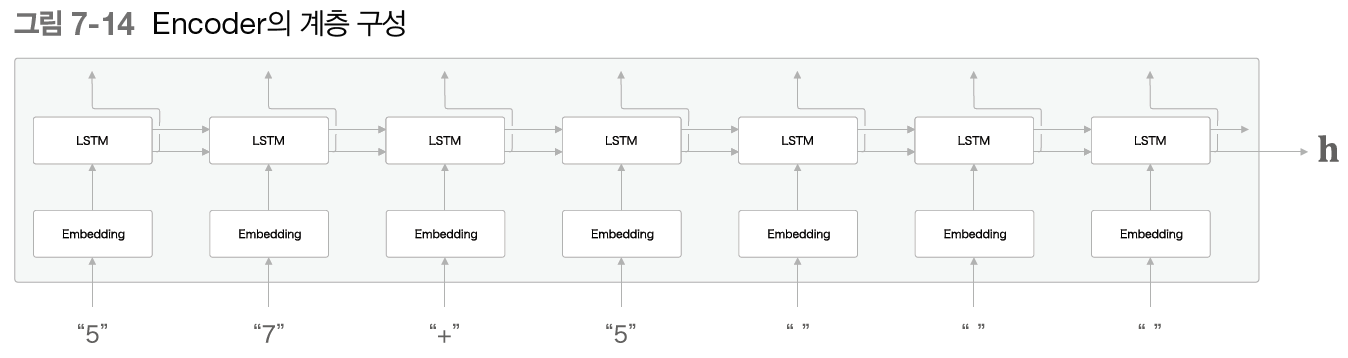

- input -> Embed -> LSTM 순으로 데이터가 흐르게 된다
- forward 최종 단계에서는 LSTM층에서 생성된 은닉벡터의 가장 마지막 부분이 output으로 생성된다

In [1]:
#Encoder 구현
import sys
sys.path.append(r'C:\Users\myunghoon_k\OneDrive - UOS\bitamin\dl_nlp_study\deep-learning-from-scratch-2-master')
import numpy as np
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f') #임베딩 단계 파라미터
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') #임베딩 -> LSTM
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') #LSTM 내부
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = False) 
        #stateful = False로 하여서 은닉계층 상태를 유지하지 않음
        #이는 짧은 시계열 데이터 임을 생각하여서 진행하는 것
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :] #가장 마지막의 가중치만 뽑음. 이를 Decoder로 보낼것
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh #마지막 위치에 해당하는 값만 dh로 채우고 나머지는 모두 0의 값을 가지는 텐서 생성
        
        dout= self.lstm.backward(dhs)
        dout= self.embed.backward(dout)
        return dout

### 2. Decoder 
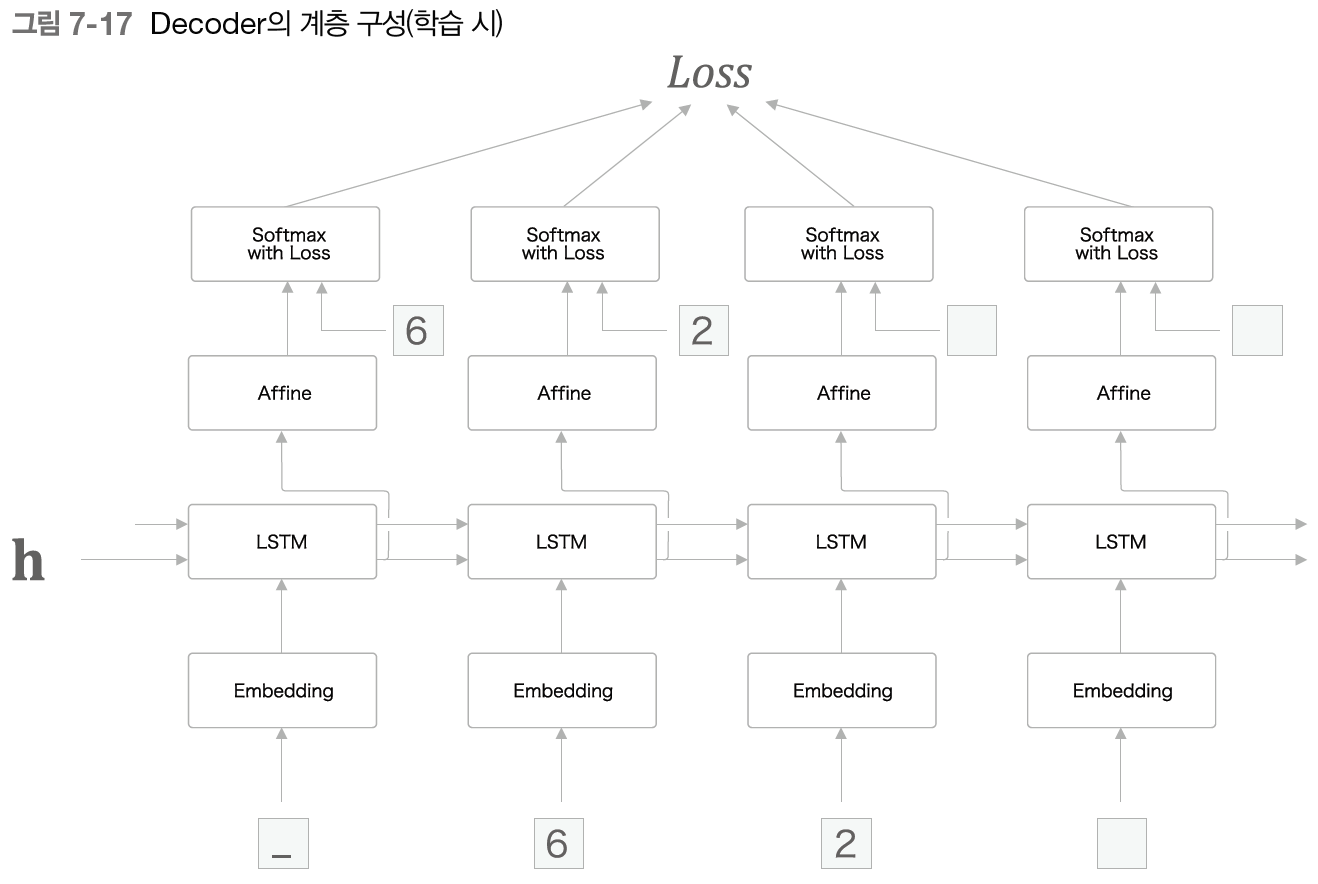

- Ecndoer에서 생성된 h와 정답에 해당하는 input을 받아서 Embed -> LSTM -> Affine -> Softmax층으로 전달
- 이 문제의 경우에는 softmax가 아닌 argmax 방식을 적용
    - 기존의 softmax 방식은 답을 확률값을 산출하므로 답을 '확률적'으로 생성
    - 수식의 답 문제는 단 하나만이 존재하므로 '결정적'인 답을 산출해야함
    - 따라서 산출된 score의 가장 상위 값만을 산출하는 argmax 방식을 사용

In [2]:
#Decoder 구현
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f') #임베딩 단계 파라미터
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') #임베딩 -> LSTM
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') #LSTM 내부
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True) 
        #Encoder와 달리 stateful = True로 옵션 설정
        #Encoder에서 받은 h정보와 정답 input의 정보를 반영해야 하므로 True로 설정한 것으로 추정
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore): #dscore는 최상단 Softmax with Loss 층에서 받은 역전파 값임
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh 
        #Decoder에서 전파된 dh를 Encoder에서 받아서 그대로 역전파를 수행함
        #이 dh의 최하단 부분 + 0으로 채워진 텐서가 Encoder의 초기 역전파 값으로 사용됨
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

In [3]:
# seq2seq 클래스 구현

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:] #정답은 input의 다음 단어가 되어야 하므로 '1:' 로 설정
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout = 1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

Q 77+85  
T 162 
X 158 
---
Q 975+164
T 1139
X 1107
---
Q 582+84 
T 666 
X 658 
---
Q 8+155  
T 163 
X 158 
---
Q 367+55 
T 422 
X 411 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1009
---
Q 830+597
T 1427
X 1410
---
Q 26+838 
T 864 
X 853 
---
Q 143+93 
T 236 
X 226 
---
검증 정확도 2.940%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.01
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 1.00
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 1.04
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 1.05
| 에폭 9 |  반복 161 / 351 | 시간 5[s] | 손실 1.04
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 1.00
| 에폭 9 |  반복 201 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 221 / 351 | 시간 7[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 301 / 351 | 시간 9[s] | 손실 0.98
| 에폭 9 |  반복 321 / 351 |

| 에폭 16 |  반복 181 / 351 | 시간 5[s] | 손실 0.86
| 에폭 16 |  반복 201 / 351 | 시간 5[s] | 손실 0.85
| 에폭 16 |  반복 221 / 351 | 시간 6[s] | 손실 0.93
| 에폭 16 |  반복 241 / 351 | 시간 7[s] | 손실 0.85
| 에폭 16 |  반복 261 / 351 | 시간 7[s] | 손실 0.85
| 에폭 16 |  반복 281 / 351 | 시간 8[s] | 손실 0.85
| 에폭 16 |  반복 301 / 351 | 시간 8[s] | 손실 0.86
| 에폭 16 |  반복 321 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 341 / 351 | 시간 10[s] | 손실 0.86
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1120
---
Q 582+84 
T 666 
X 662 
---
Q 8+155  
T 163 
X 159 
---
Q 367+55 
T 422 
X 412 
---
Q 600+257
T 857 
X 859 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1424
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 229 
---
검증 정확도 6.100%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.85
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.86
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.86
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.84
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.84
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.86
| 에폭 17 |  반복 121 / 351 | 시간 3[s] | 손실 0.85
| 에폭 17

검증 정확도 8.360%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.76
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.81
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.79
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.81
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.79
| 에폭 24 |  반복 101 / 351 | 시간 2[s] | 손실 0.84
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.77
| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.77
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.76
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.76
| 에폭 24 |  반복 201 / 351 | 시간 5[s] | 손실 0.79
| 에폭 24 |  반복 221 / 351 | 시간 6[s] | 손실 0.78
| 에폭 24 |  반복 241 / 351 | 시간 6[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 7[s] | 손실 0.77
| 에폭 24 |  반복 281 / 351 | 시간 8[s] | 손실 0.77
| 에폭 24 |  반복 301 / 351 | 시간 8[s] | 손실 0.77
| 에폭 24 |  반복 321 / 351 | 시간 9[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 9[s] | 손실 0.78
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 661 
---
Q 8+155  
T 163 
X 165 
---
Q 367+55 
T 422 
X 425 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1063
---
Q 83

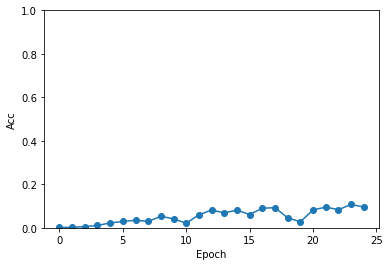

In [4]:
#seq2seq 모델 학습 및 평가
import matplotlib.pyplot as plt
from dataset import sequence
from mh_common.mh_optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

#input 생성
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

#하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

#모델, 옵티마이저, 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = [] #정답률 추이를 확인하기 위해 정답률(정확도)를 담는 객체
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1, batch_size = batch_size, max_grad = max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10 #초기 10개의 케이스만 학습과정의 변화를 직접 확인하기 위함
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(0, 1.0)
plt.show()
    #mh_time_layers에 문제가 있어서 학습이 제대로 진행되지 않아 common의 time_layers로 교체함

## seq2seq 개선
- 위에서 구현한 seq2seq 기본 모델의 학습과정에 일부 작업을 취해서 성능 개선의 효과를 이루고자 함

### 1. input 데이터 seqeunce 반전 (Reverse)
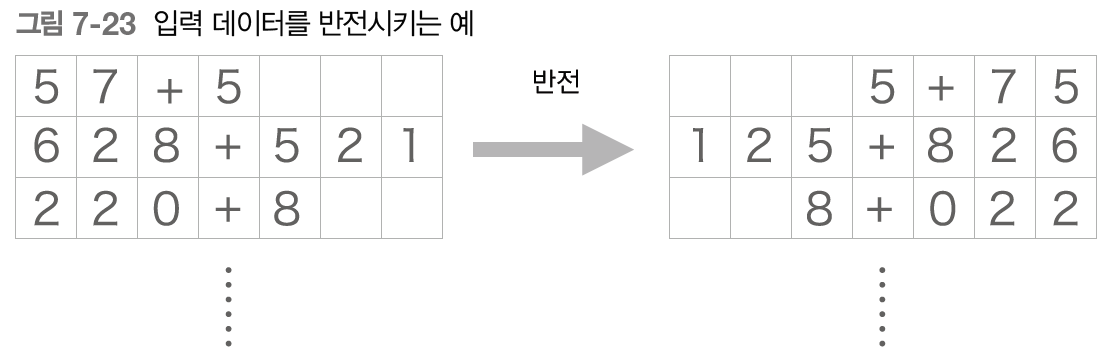
- 모델의 학습은 '나는 고양이 로소이다' -> 'I am a cat' 순으로 이뤄지는데
- 이는 input을 output으로 학습하기 까지 많은 과정을 거치게된다.
    - 즉 '나는'에 관한 학습을 하여 'I'를 내기 위해서는 '고양이 로소이다'를 거쳐야 한다
    - 따라서 parameter학습 및 역전파에 많은 시간이 걸린데
- 그런데 input의 sequence를 반전시키면 학습하고자 하는 단어의 정답 산출이 직접적으로 연결이 되게 된다
    - 즉 '로소이다 고양이 는나'에서 '는나'는 바로 'I'와 연결이 되게 된다. 
    - 특정 단어의 정답을 맞추기 위한 학습 시간이 줄어들게 되므로 minimum에 도달하는 시간 또한 축소된다

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1000
---
Q  48+285
T 666 
X 1001
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1001
---
Q 752+006
T 857 
X 1000
---
Q 292+167
T 1053
X 1000
---
Q 795+038
T 1427
X 1000
---
Q  838+6

Q   58+77
T 162 
X 163 
---
Q 461+579
T 1139
X 1134
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
X 162 
---
Q  55+763
T 422 
X 423 
---
Q 752+006
T 857 
X 759 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1431
---
Q  838+62
T 864 
X 866 
---
Q  39+341
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 5[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 7[s] | 손실 0.53
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 0.54
| 에폭 9 |  반복 301 / 351 | 시간 8[s] | 손실 0.54
| 에폭 9 |  반복 321 / 351 

| 에폭 16 |  반복 161 / 351 | 시간 4[s] | 손실 0.37
| 에폭 16 |  반복 181 / 351 | 시간 5[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 5[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 6[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 6[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 7[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 8[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 8[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 9[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 9[s] | 손실 0.37
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1142
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 858 
---
Q 292+167
T 1053
X 1054
---
Q 795+038
T 1427
X 1430
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.36
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.35
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.36
| 에폭 17 |  반복 101 / 351 | 시간 2[s] | 손실 0.34
| 에폭 17

검증 정확도 45.140%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 5[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 6[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 8[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 9[s] | 손실 0.28
| 에폭 24 |  반복 321 / 351 | 시간 9[s] | 손실 0.27
| 에폭 24 |  반복 341 / 351 | 시간 10[s] | 손실 0.29
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1140
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
X 421 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
X 1054
---
Q 

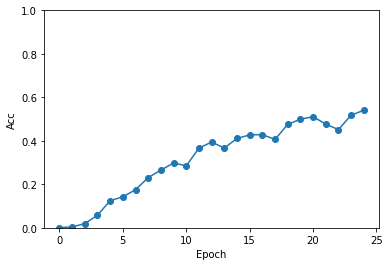

In [6]:
#input reverse적용 학습
#input 생성
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

#하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

#모델, 옵티마이저, 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = [] #정답률 추이를 확인하기 위해 정답률(정확도)를 담는 객체
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1, batch_size = batch_size, max_grad = max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10 #초기 10개의 케이스만 학습과정의 변화를 직접 확인하기 위함
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(0, 1.0)
plt.show()
    #입력 반전이전 보다 훨씬 빠른속도로 학습이 진행되어 acc가 빠르게 향상됨

### 2.  h 엿보기 (Peeky)
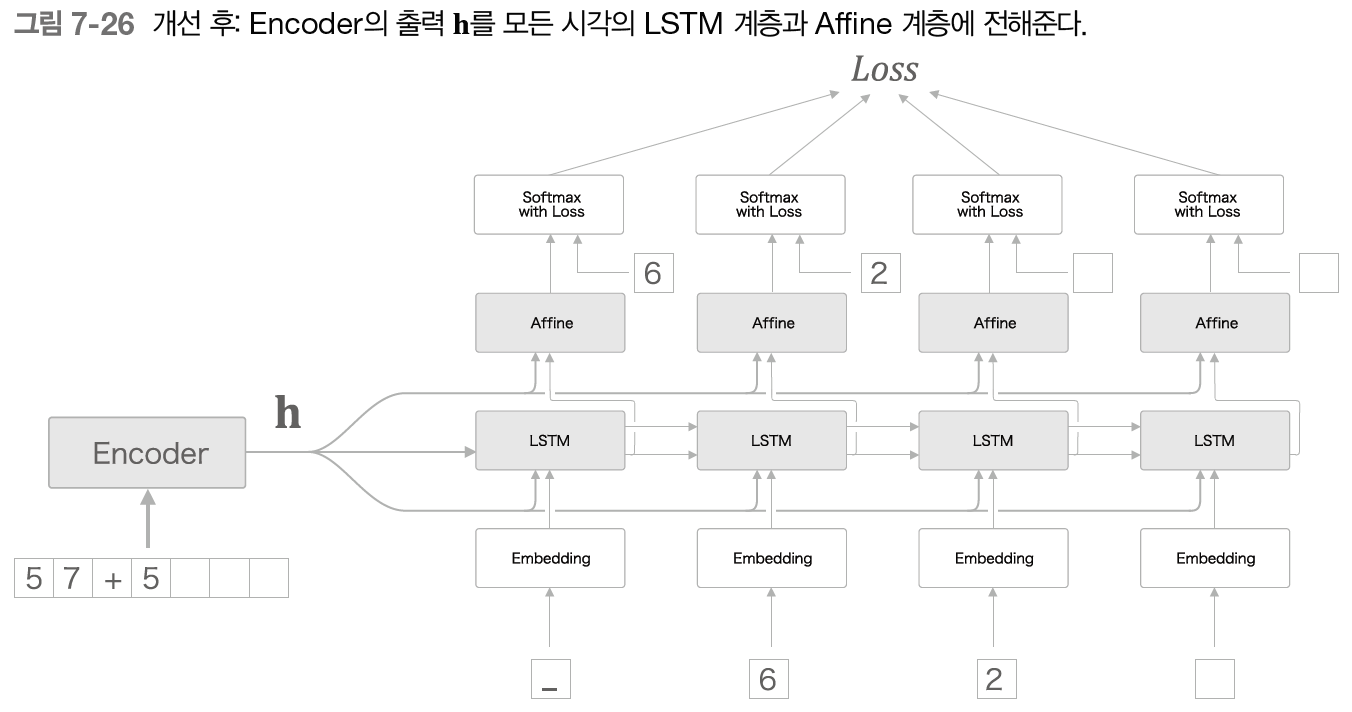
- 기존 모델에서는 Encoder의 h가 Decoder의 첫 LSTM학습에만 사용되었음
- 즉 Affine, Embed 계층에서는 h의 정보없이 학습이 되는 상태
- Decoder에 투입된느 유일한 input의 학습정보 h를 보다 많은 계층의 학습에 사용되도록 다른계층이 h를 엿보도록(Peek) 모델 구조를 일부 수정
    - Embed Output에 해당하는 은닉벡터에 H의 정보를 Concat하기
    - LSTM output에 해당하는 은닉벡터에 H의 정보를 Concat하기

In [7]:
#peeky seq2seq 구현하기

#peeky Decoder 구현
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f') 
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(D)).astype('f') 
        #H가 concat되므로 그만큼 차원이 늘어나야하기 때문에 H의 차원수를 더해주기
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') 
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None
        
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        #encoder를 통해 생성된 h를 산출할 시점 T만큼 복사하고 이를 다시 배치사이즈 N형태로 미니배치 형식으로 데이터 변환
        out = np.concatenate((hs, out), axis=2) #h의 정보를 Embed output에 concat
        
        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis = 2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache
        
        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H] 
        #concat을 하였기 때문에 concat전의 흐름으로 각각 역전파를 실시하여야 한다
        #따라서 H의 차원수를 기준으로 인덱싱하여서 역전파할 객체들을 나눠준다
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        #embed층 역시 output에서 h와 concat을 하였으므로 다시 객체를 둘로 나눠준다
        self.embed.backward(dembed)
        
        dhs = dhs0 + dhs1 #hs가 repeat노드를 통해 생성되었으므로 역전파는 생성된 흐름들을 다시 더해주면 된다
        dh = self.lstm.dh + np.sum(dhs, axis = 1) #다시 dhs와 원래 lstm의 역전파값 dh를 더하여서 이 값을 최종 encoder 역전파 값으로 보낸다
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)
        
        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H) #각 단어마다 하나씩 은닉 h가 입력되기 위한 peeky_h를 생성
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)
            
        return sampled

In [8]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.45
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.15
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.95
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.84
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.81
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.80
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.75
| 에폭 1 |  반복 241 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 281 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 9[s] | 손실 1.73
| 에폭 1 |  반복 321 / 351 | 시간 10[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 10[s] | 손실 1.72
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1013
---
Q  48+285
T 666 
X 102 
---
Q   551+8
T 163 
X 101 
---
Q  55+763
T 422 
X 102 
---
Q 752+006
T 857 
X 1023
---
Q 292+167
T 1053
X 1023
---
Q 795+038
T 1427
X 1113
---
Q  838

Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1239
---
Q  48+285
T 666 
X 665 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
O 1427
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
O 236 
---
검증 정확도 75.620%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.25
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.24
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.24
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.24
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.23
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.23
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 0.22
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.22
| 에폭 9 |  반복 161 / 351 | 시간 5[s] | 손실 0.21
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 0.21
| 에폭 9 |  반복 201 / 351 | 시간 6[s] | 손실 0.21
| 에폭 9 |  반복 221 / 351 | 시간 7[s] | 손실 0.20
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 0.19
| 에폭 9 |  반복 261 / 351 | 시간 8[s] | 손실 0.19
| 에폭 9 |  반복 281 / 351 | 시간 9[s] | 손실 0.19
| 에폭 9 |  반복 301 / 351 | 시간 9[s] | 손실 0.19
| 에폭 9 |  반복 321 / 351 

| 에폭 16 |  반복 161 / 351 | 시간 5[s] | 손실 0.03
| 에폭 16 |  반복 181 / 351 | 시간 5[s] | 손실 0.03
| 에폭 16 |  반복 201 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 221 / 351 | 시간 7[s] | 손실 0.03
| 에폭 16 |  반복 241 / 351 | 시간 7[s] | 손실 0.03
| 에폭 16 |  반복 261 / 351 | 시간 8[s] | 손실 0.03
| 에폭 16 |  반복 281 / 351 | 시간 9[s] | 손실 0.03
| 에폭 16 |  반복 301 / 351 | 시간 9[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 10[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 11[s] | 손실 0.03
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
O 1427
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
O 236 
---
검증 정확도 95.880%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.04
| 에폭 

검증 정확도 99.320%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.01
| 에폭 24 |  반복 161 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 201 / 351 | 시간 6[s] | 손실 0.01
| 에폭 24 |  반복 221 / 351 | 시간 7[s] | 손실 0.01
| 에폭 24 |  반복 241 / 351 | 시간 7[s] | 손실 0.00
| 에폭 24 |  반복 261 / 351 | 시간 8[s] | 손실 0.00
| 에폭 24 |  반복 281 / 351 | 시간 9[s] | 손실 0.01
| 에폭 24 |  반복 301 / 351 | 시간 9[s] | 손실 0.01
| 에폭 24 |  반복 321 / 351 | 시간 10[s] | 손실 0.01
| 에폭 24 |  반복 341 / 351 | 시간 11[s] | 손실 0.03
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
---
Q

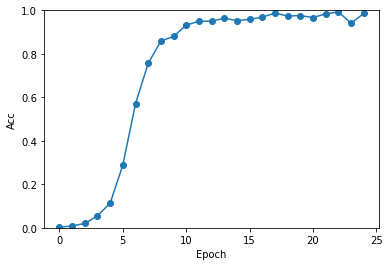

In [9]:
#PeekySeq2seq 모델이용 학습
#input reverse 또한 이용

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

#하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

#모델, 옵티마이저, 트레이너 생성
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = [] #정답률 추이를 확인하기 위해 정답률(정확도)를 담는 객체
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1, batch_size = batch_size, max_grad = max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10 #초기 10개의 케이스만 학습과정의 변화를 직접 확인하기 위함
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(0, 1.0)
plt.show()